# 1. Import Module

In [1]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.Descriptors import MolLogP
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit.Chem import Descriptors
from rdkit.Chem import PandasTools
from rdkit.DataStructs import ExplicitBitVect
import sys
import multiprocessing
from standardiser import break_bonds, neutralise, rules, unsalt
from standardiser.utils import StandardiseException, sanity_check
%reload_ext autoreload
%autoreload 2
def warn(*args, **kwargs):
    pass 
import warnings
warnings.filterwarnings("ignore")
warnings.warn = warn
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import sys
from sklearn.metrics import cohen_kappa_score
import csv
from rdkit.Chem import MACCSkeys
from sklearn.model_selection import ShuffleSplit
import _pickle as cPickle
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit    
import bz2
from glob import glob
import _pickle as cPickle
import pickle
# Draw.DrawingOptions.atomLabelFontFace = "DejaVu Sans"
# Draw.DrawingOptions.atomLabelFontSize = 18




# LOAD DATASET TRAINING


In [2]:
import pandas as pd
from rdkit import Chem

# Function to read Excel file into DataFrame
def load_excel_to_df(filename):
    df = pd.read_excel(filename)
    return df

# Convert strings back to lists of integers
def string_to_list(bit_string):
    if isinstance(bit_string, str):
        return list(map(int, bit_string.strip('[]').split(', ')))
    else:
        return bit_string

# Load Excel file
train_df = load_excel_to_df(r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Train_set_Dermal_balanced_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx")

# Apply the string-to-list conversion for the fingerprint columns
fingerprint_columns = ['Morgan_Descriptors', 'MACCS_Descriptors', 'APF_Descriptors']
for col in fingerprint_columns:
    if col in train_df.columns:
        train_df[col] = train_df[col].apply(string_to_list)
    else:
        print(f"Warning: Column {col} not found in Excel file!")

# Define combined_df as train_df
combined_df = train_df

print("Combined DataFrame:")
print(combined_df.head())


Combined DataFrame:
                                              SMILES  Outcome  \
0  CCCCCCCCC=CCCCCCCCC(=O)OCC(CC)(CO)COC(=O)CCCCC...        0   
1            CC12C=CC(=O)C=C1CCC1C2CCC2(C)C(=O)CCC12        0   
2                      CC(C)N(C(=O)SCC(Cl)=CCl)C(C)C        0   
3                                    CC1(C)OCC(CO)O1        0   
4                                      O=C=Nc1ccccc1        0   

                                  Morgan_Descriptors  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...   
2  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                   MACCS_Descriptors  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3  [0, 0, 0, 0, 0, 0, 0, 0, 

In [3]:
combined_df.keys()

Index(['SMILES', 'Outcome', 'Morgan_Descriptors', 'MACCS_Descriptors',
       'APF_Descriptors', 'Molecular Weight', 'logP', 'LabuteASA', 'TPSA',
       'AMW', 'NumRotatableBonds', 'NumAromaticRings', 'NumSaturatedRings',
       'NumAliphaticRings', 'NumAromaticHeterocycles',
       'NumSaturatedHeterocycles', 'NumAliphaticHeterocycles',
       'NumAromaticCarbocycles', 'NumSaturatedCarbocycles',
       'NumAliphaticCarbocycles', 'FractionCSP3', 'Chi0v', 'Chi1v', 'Chi2v',
       'Chi3v', 'Chi4v', 'Chi1n', 'Chi2n', 'Chi3n', 'Chi4n', 'HallKierAlpha',
       'Heavy Atom Count', 'Ring Count', 'Num H Donors', 'Num H Acceptors',
       'ALogP', 'ALogp2', 'AMR', 'MLogP', 'nAtomP', 'naAromAtom', 'bpol', 'nB',
       'ECCEN', 'fragC', 'nHBAcc', 'nHBDon', 'nAtomLAC', 'nAtomLC',
       'PetitjeanNumber', 'nRotB', 'LipinskiFailures', 'TopoPSA', 'VAdjMat',
       'XLogP', 'Fsp3'],
      dtype='object')

In [4]:
combine_df= combined_df.sort_values(['Outcome'], ascending=True)
combined_df['RowID'] = combined_df.index
combined_df.head(100)

,SMILES,Outcome,Morgan_Descriptors,MACCS_Descriptors,APF_Descriptors,Molecular Weight,logP,LabuteASA,TPSA,AMW,...,nAtomLAC,nAtomLC,PetitjeanNumber,nRotB,LipinskiFailures,TopoPSA,VAdjMat,XLogP,Fsp3,RowID
0,CCCCCCCCC=CCCCCCCCC(=O)OCC(CC)(CO)COC(=O)CCCCC...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",663.081,12.5365,291.667040,72.83,663.081,...,18,41,0.500000,38,3,72.83,6.523562,17.303,0.857143,0
1,CC12C=CC(=O)C=C1CCC1C2CCC2(C)C(=O)CCC12,0,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",284.399,3.8634,126.228723,34.14,284.399,...,0,0,0.500000,0,0,34.14,5.584963,3.496,0.684211,1
2,CC(C)N(C(=O)SCC(Cl)=CCl)C(C)C,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",270.225,4.2774,105.985125,20.31,270.225,...,3,9,0.500000,6,0,45.61,4.807355,3.440,0.700000,2
3,CC1(C)OCC(CO)O1,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",132.159,0.1302,54.579455,38.69,132.159,...,0,2,0.400000,1,0,38.69,4.169925,-0.038,1.000000,3
4,O=C=Nc1ccccc1,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",119.123,1.6539,52.853190,29.43,119.123,...,0,3,0.500000,1,0,29.43,4.169925,3.286,0.000000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,OCCCCCCCCCCO,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",174.284,2.0918,75.612198,40.46,174.284,...,10,12,0.454545,9,0,40.46,4.459432,2.500,1.000000,95
96,O=[N+]([O-])NC1=NCCN1Cc1ccc(Cl)nc1,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",255.665,0.6879,102.236385,83.66,255.665,...,0,3,0.500000,4,0,83.66,5.169925,2.294,0.333333,96
97,CCCCOCCOP(=O)(OCCOCCCC)OCCOCCCC,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...",398.477,4.5944,159.174149,72.45,398.477,...,4,17,0.500000,21,1,82.26,5.643856,2.790,1.000000,97
98,O=C(CO)Oc1ccc(Cl)cc1Cl,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",221.039,1.8911,84.837121,46.53,221.039,...,2,4,0.500000,3,0,46.53,4.700440,2.014,0.125000,98


In [5]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Label encoding
le = LabelEncoder()
outcomes = np.unique(combined_df['Outcome'])
le.fit(outcomes)
y = le.transform(combined_df['Outcome'])

# Hasil
classes, counts = np.unique(y, return_counts=True)

print("Classes                          : ", classes)
print("Number of cpds in each class     : ", counts)
print("Total number of cpds             : ", len(y))

Classes                          :  [0 1]
Number of cpds in each class     :  [305 306]
Total number of cpds             :  611


In [6]:
S = pd.Series(le.transform(combined_df['Outcome']))  # Sama dengan y

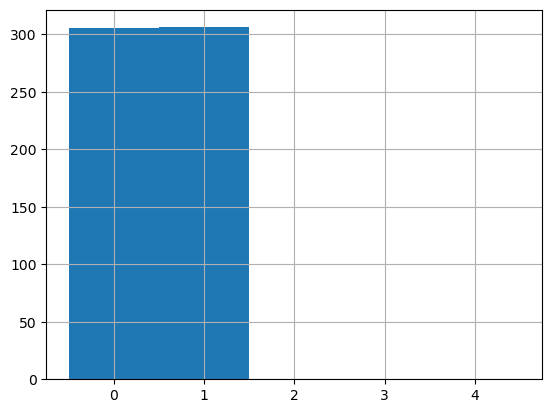

In [7]:
ax = S.hist(bins=np.arange(-0.5,5))
ax.set_xticks(range(0,5))
#info

In [8]:
# Target
y = np.int32(S)  # pastikan S sudah didefinisikan

# Fingerprint arrays
x_maccs = np.array(list(combined_df['MACCS_Descriptors']))
x_morgan = np.array(list(combined_df['Morgan_Descriptors']))
x_apf = np.array(list(combined_df['APF_Descriptors']))  # ditambahkan APF


# MORGAN_RF

In [9]:
import pandas as pd
import numpy as np
from sklearn.metrics import make_scorer, cohen_kappa_score, accuracy_score, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import joblib
import os

# ==========================
# 1️⃣ Define features and target
# ==========================
# x_morgan, y sudah didefinisikan sebelumnya

# ==========================
# 2️⃣ Hyperparameter grid
# ==========================
paramgrid = {
    "max_features": [
        x_morgan.shape[1], x_morgan.shape[1] // 2, x_morgan.shape[1] // 4, x_morgan.shape[1] // 12, x_morgan.shape[1] // 10,
        x_morgan.shape[1] // 7, x_morgan.shape[1] // 5, x_morgan.shape[1] // 3
    ],
    "n_estimators": [10, 100, 300, 500],
}

# ==========================
# 3️⃣ Scoring function
# ==========================
kappa_scorer = make_scorer(cohen_kappa_score, weights='quadratic')

# ==========================
# 4️⃣ Cross-validation for performance reporting
# ==========================
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Lists to store metrics
accuracies, auc_scores, precisions, recalls, f1_scores = [], [], [], [], []
specificities, sensitivity_scores, ppvs, npvs, ccrs = [], [], [], [], []
confusion_matrices = []

def calculate_ccr(sensitivity, specificity):
    return (sensitivity + specificity) / 2

# ==========================
# 5️⃣ Loop CV to evaluate performance
# ==========================
for train_idx, test_idx in cv.split(x_morgan, y):
    X_train, X_test = x_morgan[train_idx], x_morgan[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # GridSearchCV untuk hyperparameter terbaik
    grid = GridSearchCV(
        estimator=RandomForestClassifier(class_weight='balanced'),
        param_grid=paramgrid,
        scoring=kappa_scorer,
        cv=5,  
        n_jobs=-1
    )
    
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    
    # Prediksi fold test
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:,1]
    
    # Metrics
    accuracies.append(accuracy_score(y_test, y_pred))
    auc_scores.append(roc_auc_score(y_test, y_proba))
    precisions.append(precision_score(y_test, y_pred, zero_division=0))
    recalls.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices.append(cm)
    
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    sensitivity_scores.append(sensitivity)
    specificities.append(specificity)
    
    ppvs.append(tp / (tp + fp) if (tp + fp) > 0 else 0)
    npvs.append(tn / (tn + fn) if (tn + fn) > 0 else 0)
    ccrs.append(calculate_ccr(sensitivity, specificity))

# ==========================
# 6️⃣ Report metrics
# ==========================
cv_metrics = {
    "Accuracy": np.mean(accuracies),
    "AUC": np.mean(auc_scores),
    "Precision": np.mean(precisions),
    "Recall (Sensitivity)": np.mean(sensitivity_scores),
    "F1": np.mean(f1_scores),
    "Specificity": np.mean(specificities),
    "PPV": np.mean(ppvs),
    "NPV": np.mean(npvs),
    "CCR": np.mean(ccrs)
}

for k, v in cv_metrics.items():
    print(f'CV {k}: {v:.4f}')

# ==========================
# 7️⃣ Train final model on full dataset
# ==========================
grid_final = GridSearchCV(
    estimator=RandomForestClassifier(class_weight='balanced'),
    param_grid=paramgrid,
    scoring=kappa_scorer,
    cv=5,
    n_jobs=-1
)
grid_final.fit(x_morgan, y)
final_model = grid_final.best_estimator_

# ==========================
# 8️⃣ Save final model
# ==========================
model_folder = r'C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model'
os.makedirs(model_folder, exist_ok=True)
model_path = os.path.join(model_folder, 'FDAMDD_rf_morgan.pkl')
joblib.dump(final_model, model_path, compress=9)
print("Final Random Forest model saved successfully!")

# ==========================
# 9️⃣ Save CV metrics report
# ==========================
metrics_df = pd.DataFrame([cv_metrics])
metrics_path = os.path.join(model_folder, 'Dermal_rf_morgan_CV_metrics.xlsx')
metrics_df.to_excel(metrics_path, index=False)
print(f"CV metrics report saved successfully at: {metrics_path}")


CV Accuracy: 0.7233
CV AUC: 0.8177
CV Precision: 0.7439
CV Recall (Sensitivity): 0.6823
CV F1: 0.7091
CV Specificity: 0.7640
CV PPV: 0.7439
CV NPV: 0.7098
CV CCR: 0.7231
Final Random Forest model saved successfully!
CV metrics report saved successfully at: C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model\Dermal_rf_morgan_CV_metrics.xlsx


# MACCS_RF

In [10]:
import pandas as pd
import numpy as np
from sklearn.metrics import make_scorer, cohen_kappa_score, accuracy_score, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import joblib
from tqdm import tqdm
import os

# ==========================
# Features and target
# ==========================
# x_maccs, y sudah didefinisikan sebelumnya

# ==========================
# Hyperparameter grid
# ==========================
paramgrid = {
    "max_features": [
        x_maccs.shape[1], x_maccs.shape[1] // 2, x_maccs.shape[1] // 4,
        x_maccs.shape[1] // 12, x_maccs.shape[1] // 10,
        x_maccs.shape[1] // 7, x_maccs.shape[1] // 5, x_maccs.shape[1] // 3
    ],
    "n_estimators": [10, 100, 300, 500],
}

# ==========================
# Scoring function
# ==========================
kappa_scorer = make_scorer(cohen_kappa_score, weights='quadratic')

# ==========================
# 10-fold CV
# ==========================
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

accuracies, auc_scores, precisions, recalls, f1_scores = [], [], [], [], []
specificities, sensitivity_scores, ppvs, npvs, ccrs = [], [], [], [], []
confusion_matrices = []

def calculate_ccr(sensitivity, specificity):
    return (sensitivity + specificity) / 2

# ==========================
# Outer CV loop dengan progress bar
# ==========================
for fold_idx, (train_idx, test_idx) in enumerate(tqdm(cv.split(x_maccs, y), total=cv.get_n_splits(), desc="Outer CV folds")):
    X_train, X_test = x_maccs[train_idx], x_maccs[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    grid = GridSearchCV(
        estimator=RandomForestClassifier(class_weight='balanced'),
        param_grid=paramgrid,
        scoring=kappa_scorer,
        cv=5,
        n_jobs=-1,
        verbose=2
    )
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:,1]
    
    # Metrics
    accuracies.append(accuracy_score(y_test, y_pred))
    auc_scores.append(roc_auc_score(y_test, y_proba))
    precisions.append(precision_score(y_test, y_pred, zero_division=0))
    recalls.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices.append(cm)
    
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    sensitivity_scores.append(sensitivity)
    specificities.append(specificity)
    
    ppvs.append(tp / (tp + fp) if (tp + fp) > 0 else 0)
    npvs.append(tn / (tn + fn) if (tn + fn) > 0 else 0)
    ccrs.append(calculate_ccr(sensitivity, specificity))

# ==========================
# Report metrics
# ==========================
cv_metrics = {
    "Accuracy": np.mean(accuracies),
    "AUC": np.mean(auc_scores),
    "Precision": np.mean(precisions),
    "Recall (Sensitivity)": np.mean(sensitivity_scores),
    "F1": np.mean(f1_scores),
    "Specificity": np.mean(specificities),
    "PPV": np.mean(ppvs),
    "NPV": np.mean(npvs),
    "CCR": np.mean(ccrs)
}

for k, v in cv_metrics.items():
    print(f'CV {k}: {v:.4f}')

# ==========================
# Fit final model di seluruh dataset
# ==========================
print("Training final model on full dataset...")
grid_final = GridSearchCV(
    estimator=RandomForestClassifier(class_weight='balanced'),
    param_grid=paramgrid,
    scoring=kappa_scorer,
    cv=5,
    n_jobs=-1,
    verbose=2
)
grid_final.fit(x_maccs, y)
final_model = grid_final.best_estimator_

# ==========================
# Save final model
# ==========================
model_folder = r'C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model'
os.makedirs(model_folder, exist_ok=True)

model_path = os.path.join(model_folder, 'FDAMDD_rf_macckeys.pkl')
joblib.dump(final_model, model_path, compress=9)
print("Final Random Forest model saved successfully!")

# ==========================
# Save CV metrics report
# ==========================
metrics_df = pd.DataFrame([cv_metrics])
metrics_path = os.path.join(model_folder, 'Dermal_rf_macckeys_CV_metrics.xlsx')
metrics_df.to_excel(metrics_path, index=False)
print(f"CV metrics report saved successfully at: {metrics_path}")


Outer CV folds:   0%|                                                                           | 0/10 [00:00<?, ?it/s]

Fitting 5 folds for each of 32 candidates, totalling 160 fits


Outer CV folds:  10%|██████▋                                                            | 1/10 [00:20<03:07, 20.88s/it]

Fitting 5 folds for each of 32 candidates, totalling 160 fits


Outer CV folds:  20%|█████████████▍                                                     | 2/10 [00:41<02:46, 20.85s/it]

Fitting 5 folds for each of 32 candidates, totalling 160 fits


Outer CV folds:  30%|████████████████████                                               | 3/10 [01:02<02:26, 20.99s/it]

Fitting 5 folds for each of 32 candidates, totalling 160 fits


Outer CV folds:  40%|██████████████████████████▊                                        | 4/10 [01:13<01:40, 16.79s/it]

Fitting 5 folds for each of 32 candidates, totalling 160 fits


Outer CV folds:  50%|█████████████████████████████████▌                                 | 5/10 [01:28<01:20, 16.16s/it]

Fitting 5 folds for each of 32 candidates, totalling 160 fits


Outer CV folds:  60%|████████████████████████████████████████▏                          | 6/10 [01:45<01:05, 16.44s/it]

Fitting 5 folds for each of 32 candidates, totalling 160 fits


Outer CV folds:  70%|██████████████████████████████████████████████▉                    | 7/10 [02:06<00:53, 17.91s/it]

Fitting 5 folds for each of 32 candidates, totalling 160 fits


Outer CV folds:  80%|█████████████████████████████████████████████████████▌             | 8/10 [02:24<00:36, 18.01s/it]

Fitting 5 folds for each of 32 candidates, totalling 160 fits


Outer CV folds:  90%|████████████████████████████████████████████████████████████▎      | 9/10 [02:42<00:18, 18.19s/it]

Fitting 5 folds for each of 32 candidates, totalling 160 fits


Outer CV folds: 100%|██████████████████████████████████████████████████████████████████| 10/10 [02:59<00:00, 17.95s/it]


CV Accuracy: 0.7561
CV AUC: 0.8447
CV Precision: 0.7803
CV Recall (Sensitivity): 0.7188
CV F1: 0.7469
CV Specificity: 0.7931
CV PPV: 0.7803
CV NPV: 0.7383
CV CCR: 0.7560
Training final model on full dataset...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Final Random Forest model saved successfully!
CV metrics report saved successfully at: C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model\Dermal_rf_macckeys_CV_metrics.xlsx


# APF_RF

In [11]:
import pandas as pd
import numpy as np
from sklearn.metrics import make_scorer, cohen_kappa_score, accuracy_score, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import joblib
from tqdm import tqdm
import os

# ==========================
# Features and target
# ==========================
# x_apf, y sudah didefinisikan sebelumnya
# Pastikan y = np.int32(S)

# ==========================
# Hyperparameter grid
# ==========================
paramgrid = {
    "max_features": [
        x_apf.shape[1], x_apf.shape[1] // 2, x_apf.shape[1] // 4,
        x_apf.shape[1] // 12, x_apf.shape[1] // 10,
        x_apf.shape[1] // 7, x_apf.shape[1] // 5, x_apf.shape[1] // 3
    ],
    "n_estimators": [10, 100, 300, 500],
}

# ==========================
# Scoring function
# ==========================
kappa_scorer = make_scorer(cohen_kappa_score, weights='quadratic')

# ==========================
# 10-fold CV
# ==========================
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

accuracies, auc_scores, precisions, recalls, f1_scores = [], [], [], [], []
specificities, sensitivity_scores, ppvs, npvs, ccrs = [], [], [], [], []
confusion_matrices = []

def calculate_ccr(sensitivity, specificity):
    return (sensitivity + specificity) / 2

# ==========================
# Outer CV loop dengan progress bar
# ==========================
for fold_idx, (train_idx, test_idx) in enumerate(tqdm(cv.split(x_apf, y), total=cv.get_n_splits(), desc="Outer CV folds")):
    X_train, X_test = x_apf[train_idx], x_apf[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    grid = GridSearchCV(
        estimator=RandomForestClassifier(class_weight='balanced'),
        param_grid=paramgrid,
        scoring=kappa_scorer,
        cv=5,
        n_jobs=-1,
        verbose=2
    )
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:,1]
    
    # Metrics
    accuracies.append(accuracy_score(y_test, y_pred))
    auc_scores.append(roc_auc_score(y_test, y_proba))
    precisions.append(precision_score(y_test, y_pred, zero_division=0))
    recalls.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices.append(cm)
    
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    sensitivity_scores.append(sensitivity)
    specificities.append(specificity)
    
    ppvs.append(tp / (tp + fp) if (tp + fp) > 0 else 0)
    npvs.append(tn / (tn + fn) if (tn + fn) > 0 else 0)
    ccrs.append(calculate_ccr(sensitivity, specificity))

# ==========================
# Report metrics
# ==========================
cv_metrics = {
    "Accuracy": np.mean(accuracies),
    "AUC": np.mean(auc_scores),
    "Precision": np.mean(precisions),
    "Recall (Sensitivity)": np.mean(sensitivity_scores),
    "F1": np.mean(f1_scores),
    "Specificity": np.mean(specificities),
    "PPV": np.mean(ppvs),
    "NPV": np.mean(npvs),
    "CCR": np.mean(ccrs)
}

for k, v in cv_metrics.items():
    print(f'CV {k}: {v:.4f}')

# ==========================
# Fit final model di seluruh dataset
# ==========================
print("Training final model on full dataset...")
grid_final = GridSearchCV(
    estimator=RandomForestClassifier(class_weight='balanced'),
    param_grid=paramgrid,
    scoring=kappa_scorer,
    cv=5,
    n_jobs=-1,
    verbose=2
)
grid_final.fit(x_apf, y)
final_model = grid_final.best_estimator_

# ==========================
# Save final model & metrics report
# ==========================
model_folder = r'C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model'
os.makedirs(model_folder, exist_ok=True)

# Save model
model_path = os.path.join(model_folder, 'Dermal_rf_apf.pkl')
joblib.dump(final_model, model_path, compress=9)
print("Final Random Forest model saved successfully!")

# Save CV metrics
metrics_df = pd.DataFrame([cv_metrics])
metrics_path = os.path.join(model_folder, 'Dermal_rf_apf_CV_metrics.xlsx')
metrics_df.to_excel(metrics_path, index=False)
print(f"CV metrics report saved successfully at: {metrics_path}")


Outer CV folds:   0%|                                                                           | 0/10 [00:00<?, ?it/s]

Fitting 5 folds for each of 32 candidates, totalling 160 fits


Outer CV folds:  10%|██████▋                                                            | 1/10 [00:42<06:25, 42.86s/it]

Fitting 5 folds for each of 32 candidates, totalling 160 fits


Outer CV folds:  20%|█████████████▍                                                     | 2/10 [01:26<05:48, 43.60s/it]

Fitting 5 folds for each of 32 candidates, totalling 160 fits


Outer CV folds:  30%|████████████████████                                               | 3/10 [02:10<05:04, 43.47s/it]

Fitting 5 folds for each of 32 candidates, totalling 160 fits


Outer CV folds:  40%|██████████████████████████▊                                        | 4/10 [02:56<04:28, 44.74s/it]

Fitting 5 folds for each of 32 candidates, totalling 160 fits


Outer CV folds:  50%|█████████████████████████████████▌                                 | 5/10 [03:40<03:41, 44.22s/it]

Fitting 5 folds for each of 32 candidates, totalling 160 fits


Outer CV folds:  60%|████████████████████████████████████████▏                          | 6/10 [04:20<02:52, 43.03s/it]

Fitting 5 folds for each of 32 candidates, totalling 160 fits


Outer CV folds:  70%|██████████████████████████████████████████████▉                    | 7/10 [04:55<02:00, 40.30s/it]

Fitting 5 folds for each of 32 candidates, totalling 160 fits


Outer CV folds:  80%|█████████████████████████████████████████████████████▌             | 8/10 [05:30<01:17, 38.56s/it]

Fitting 5 folds for each of 32 candidates, totalling 160 fits


Outer CV folds:  90%|████████████████████████████████████████████████████████████▎      | 9/10 [06:06<00:37, 37.77s/it]

Fitting 5 folds for each of 32 candidates, totalling 160 fits


Outer CV folds: 100%|██████████████████████████████████████████████████████████████████| 10/10 [06:45<00:00, 40.50s/it]


CV Accuracy: 0.7495
CV AUC: 0.8085
CV Precision: 0.7859
CV Recall (Sensitivity): 0.6958
CV F1: 0.7340
CV Specificity: 0.8033
CV PPV: 0.7859
CV NPV: 0.7281
CV CCR: 0.7496
Training final model on full dataset...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Final Random Forest model saved successfully!
CV metrics report saved successfully at: C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model\Dermal_rf_apf_CV_metrics.xlsx


# MORGAN_XBOOST

In [12]:
import pandas as pd
import numpy as np
from sklearn.metrics import make_scorer, cohen_kappa_score, accuracy_score, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier
import joblib
from tqdm import tqdm
import os

# ==========================
# Features and target
# ==========================
# x_morgan, y sudah didefinisikan sebelumnya
# Pastikan y = np.int32(S) jika perlu

# ==========================
# Hyperparameter grid untuk XGBoost
# ==========================
paramgrid = {
    "max_depth": [3, 5, 7, 10],
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.1, 0.2]
}

# ==========================
# Scoring function
# ==========================
kappa_scorer = make_scorer(cohen_kappa_score, weights='quadratic')

# ==========================
# 10-fold CV
# ==========================
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

accuracies, auc_scores, precisions, recalls, f1_scores = [], [], [], [], []
specificities, sensitivity_scores, ppvs, npvs, ccrs = [], [], [], [], []
confusion_matrices = []

def calculate_ccr(sensitivity, specificity):
    return (sensitivity + specificity) / 2

# ==========================
# Outer CV loop dengan progress
# ==========================
print("Starting 10-fold cross-validation...")

for fold, (train_idx, test_idx) in enumerate(tqdm(cv.split(x_morgan, y), total=10, desc="CV Folds")):
    X_train, X_test = x_morgan[train_idx], x_morgan[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    grid = GridSearchCV(
        estimator=XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss'),
        param_grid=paramgrid,
        scoring=kappa_scorer,
        cv=5,
        verbose=1,
        n_jobs=-1
    )
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:,1]
    
    # Metrics
    accuracies.append(accuracy_score(y_test, y_pred))
    auc_scores.append(roc_auc_score(y_test, y_proba))
    precisions.append(precision_score(y_test, y_pred, zero_division=0))
    recalls.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices.append(cm)
    
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    sensitivity_scores.append(sensitivity)
    specificities.append(specificity)
    
    ppvs.append(tp / (tp + fp) if (tp + fp) > 0 else 0)
    npvs.append(tn / (tn + fn) if (tn + fn) > 0 else 0)
    ccrs.append(calculate_ccr(sensitivity, specificity))
    
    print(f"Fold {fold+1} done. Best params: {grid.best_params_}")

# ==========================
# Report metrics
# ==========================
cv_metrics = {
    "Accuracy": np.mean(accuracies),
    "AUC": np.mean(auc_scores),
    "Precision": np.mean(precisions),
    "Recall (Sensitivity)": np.mean(sensitivity_scores),
    "F1": np.mean(f1_scores),
    "Specificity": np.mean(specificities),
    "PPV": np.mean(ppvs),
    "NPV": np.mean(npvs),
    "CCR": np.mean(ccrs)
}

print("\n=== 10-Fold CV Metrics ===")
for k, v in cv_metrics.items():
    print(f'{k}: {v:.4f}')

# ==========================
# Fit final model di seluruh dataset
# ==========================
print("\nTraining final XGBoost model on full dataset with GridSearchCV...")
grid_final = GridSearchCV(
    estimator=XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss'),
    param_grid=paramgrid,
    scoring=kappa_scorer,
    cv=5,
    verbose=1,
    n_jobs=-1
)
grid_final.fit(x_morgan, y)
final_model = grid_final.best_estimator_

# ==========================
# Save final model & metrics
# ==========================
model_folder = r'C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model'
os.makedirs(model_folder, exist_ok=True)

# Save model
model_path = os.path.join(model_folder, 'Dermal_xgb_morgan.pkl')
joblib.dump(final_model, model_path, compress=9)
print("Final XGBoost model saved successfully!")

# Save CV metrics
metrics_df = pd.DataFrame([cv_metrics])
metrics_path = os.path.join(model_folder, 'Dermal_xgb_morgan_CV_metrics.xlsx')
metrics_df.to_excel(metrics_path, index=False)
print(f"CV metrics report saved successfully at: {metrics_path}")


Starting 10-fold cross-validation...


CV Folds:   0%|                                                                                 | 0/10 [00:00<?, ?it/s]

Fitting 5 folds for each of 36 candidates, totalling 180 fits


CV Folds:  10%|███████▎                                                                 | 1/10 [00:12<01:56, 12.89s/it]

Fold 1 done. Best params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


CV Folds:  20%|██████████████▌                                                          | 2/10 [00:24<01:35, 11.97s/it]

Fold 2 done. Best params: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


CV Folds:  30%|█████████████████████▉                                                   | 3/10 [00:33<01:13, 10.52s/it]

Fold 3 done. Best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


CV Folds:  40%|█████████████████████████████▏                                           | 4/10 [00:44<01:06, 11.10s/it]

Fold 4 done. Best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


CV Folds:  50%|████████████████████████████████████▌                                    | 5/10 [00:56<00:55, 11.12s/it]

Fold 5 done. Best params: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 300}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


CV Folds:  60%|███████████████████████████████████████████▊                             | 6/10 [01:05<00:42, 10.61s/it]

Fold 6 done. Best params: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


CV Folds:  70%|███████████████████████████████████████████████████                      | 7/10 [01:12<00:28,  9.48s/it]

Fold 7 done. Best params: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


CV Folds:  80%|██████████████████████████████████████████████████████████▍              | 8/10 [01:20<00:17,  8.77s/it]

Fold 8 done. Best params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


CV Folds:  90%|█████████████████████████████████████████████████████████████████▋       | 9/10 [01:27<00:08,  8.39s/it]

Fold 9 done. Best params: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 300}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


CV Folds: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [01:34<00:00,  9.48s/it]

Fold 10 done. Best params: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}

=== 10-Fold CV Metrics ===
Accuracy: 0.7397
AUC: 0.8057
Precision: 0.7496
Recall (Sensitivity): 0.7251
F1: 0.7356
Specificity: 0.7543
PPV: 0.7496
NPV: 0.7341
CCR: 0.7397

Training final XGBoost model on full dataset with GridSearchCV...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


Final XGBoost model saved successfully!
CV metrics report saved successfully at: C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model\Dermal_xgb_morgan_CV_metrics.xlsx


# MACCS_XGBOOST

In [13]:
import pandas as pd
import numpy as np
from sklearn.metrics import make_scorer, cohen_kappa_score, accuracy_score, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier
import joblib
from tqdm import tqdm
import os

# ==========================
# Features and target
# ==========================
# x_maccs, y sudah didefinisikan sebelumnya

# ==========================
# Hyperparameter grid untuk XGBoost
# ==========================
paramgrid = {
    "max_depth": [3, 5, 7, 10],
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.1, 0.2]
}

# ==========================
# Scoring function
# ==========================
kappa_scorer = make_scorer(cohen_kappa_score, weights='quadratic')

# ==========================
# 10-fold CV
# ==========================
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

accuracies, auc_scores, precisions, recalls, f1_scores = [], [], [], [], []
specificities, sensitivity_scores, ppvs, npvs, ccrs = [], [], [], [], []
confusion_matrices = []

def calculate_ccr(sensitivity, specificity):
    return (sensitivity + specificity) / 2

# ==========================
# Outer CV loop dengan progress
# ==========================
print("Starting 10-fold cross-validation for MACCS features...")

for fold, (train_idx, test_idx) in enumerate(tqdm(cv.split(x_maccs, y), total=10, desc="CV Folds")):
    X_train, X_test = x_maccs[train_idx], x_maccs[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    grid = GridSearchCV(
        estimator=XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss'),
        param_grid=paramgrid,
        scoring=kappa_scorer,
        cv=5,
        verbose=1,
        n_jobs=-1
    )
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:,1]
    
    # Metrics
    accuracies.append(accuracy_score(y_test, y_pred))
    auc_scores.append(roc_auc_score(y_test, y_proba))
    precisions.append(precision_score(y_test, y_pred, zero_division=0))
    recalls.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices.append(cm)
    
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    sensitivity_scores.append(sensitivity)
    specificities.append(specificity)
    
    ppvs.append(tp / (tp + fp) if (tp + fp) > 0 else 0)
    npvs.append(tn / (tn + fn) if (tn + fn) > 0 else 0)
    ccrs.append(calculate_ccr(sensitivity, specificity))
    
    print(f"Fold {fold+1} done. Best params: {grid.best_params_}")

# ==========================
# Report metrics
# ==========================
cv_metrics = {
    "Accuracy": np.mean(accuracies),
    "AUC": np.mean(auc_scores),
    "Precision": np.mean(precisions),
    "Recall (Sensitivity)": np.mean(sensitivity_scores),
    "F1": np.mean(f1_scores),
    "Specificity": np.mean(specificities),
    "PPV": np.mean(ppvs),
    "NPV": np.mean(npvs),
    "CCR": np.mean(ccrs)
}

print("\n=== 10-Fold CV Metrics for MACCS ===")
for k, v in cv_metrics.items():
    print(f'{k}: {v:.4f}')

# ==========================
# Fit final model di seluruh dataset
# ==========================
print("\nTraining final XGBoost model on full dataset (MACCS features)...")
grid_final = GridSearchCV(
    estimator=XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss'),
    param_grid=paramgrid,
    scoring=kappa_scorer,
    cv=5,
    verbose=1,
    n_jobs=-1
)
grid_final.fit(x_maccs, y)
final_model = grid_final.best_estimator_

# ==========================
# Save final model & metrics
# ==========================
model_folder = r'C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model'
os.makedirs(model_folder, exist_ok=True)

# Save model
model_path = os.path.join(model_folder, 'Dermal_xgb_maccs.pkl')
joblib.dump(final_model, model_path, compress=9)
print("Final XGBoost model saved successfully!")

# Save CV metrics
metrics_df = pd.DataFrame([cv_metrics])
metrics_path = os.path.join(model_folder, 'Dermal_xgb_maccs_CV_metrics.xlsx')
metrics_df.to_excel(metrics_path, index=False)
print(f"CV metrics report saved successfully at: {metrics_path}")


Starting 10-fold cross-validation for MACCS features...


CV Folds:   0%|                                                                                 | 0/10 [00:00<?, ?it/s]

Fitting 5 folds for each of 36 candidates, totalling 180 fits


CV Folds:  10%|███████▎                                                                 | 1/10 [00:02<00:20,  2.32s/it]

Fold 1 done. Best params: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 300}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


CV Folds:  20%|██████████████▌                                                          | 2/10 [00:04<00:17,  2.24s/it]

Fold 2 done. Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


CV Folds:  30%|█████████████████████▉                                                   | 3/10 [00:06<00:14,  2.14s/it]

Fold 3 done. Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


CV Folds:  40%|█████████████████████████████▏                                           | 4/10 [00:08<00:12,  2.10s/it]

Fold 4 done. Best params: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


CV Folds:  50%|████████████████████████████████████▌                                    | 5/10 [00:10<00:10,  2.09s/it]

Fold 5 done. Best params: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


CV Folds:  60%|███████████████████████████████████████████▊                             | 6/10 [00:12<00:08,  2.07s/it]

Fold 6 done. Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


CV Folds:  70%|███████████████████████████████████████████████████                      | 7/10 [00:14<00:06,  2.10s/it]

Fold 7 done. Best params: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 300}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


CV Folds:  80%|██████████████████████████████████████████████████████████▍              | 8/10 [00:16<00:04,  2.08s/it]

Fold 8 done. Best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


CV Folds:  90%|█████████████████████████████████████████████████████████████████▋       | 9/10 [00:18<00:02,  2.07s/it]

Fold 9 done. Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


CV Folds: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [00:21<00:00,  2.11s/it]

Fold 10 done. Best params: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300}

=== 10-Fold CV Metrics for MACCS ===
Accuracy: 0.7528
AUC: 0.8358
Precision: 0.7584
Recall (Sensitivity): 0.7480
F1: 0.7500
Specificity: 0.7578
PPV: 0.7584
NPV: 0.7550
CCR: 0.7529

Training final XGBoost model on full dataset (MACCS features)...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


Final XGBoost model saved successfully!
CV metrics report saved successfully at: C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model\Dermal_xgb_maccs_CV_metrics.xlsx


# APF_XGBOOST

In [14]:
import pandas as pd
import numpy as np
from sklearn.metrics import make_scorer, cohen_kappa_score, accuracy_score, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier
import joblib
from tqdm import tqdm
import os

# ==========================
# Features and target
# ==========================
# x_apf, y sudah didefinisikan sebelumnya

# ==========================
# Hyperparameter grid untuk XGBoost
# ==========================
paramgrid = {
    "max_depth": [3, 5, 7, 10],
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.1, 0.2]
}

# ==========================
# Scoring function
# ==========================
kappa_scorer = make_scorer(cohen_kappa_score, weights='quadratic')

# ==========================
# 10-fold CV
# ==========================
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

accuracies, auc_scores, precisions, recalls, f1_scores = [], [], [], [], []
specificities, sensitivity_scores, ppvs, npvs, ccrs = [], [], [], [], []
confusion_matrices = []

def calculate_ccr(sensitivity, specificity):
    return (sensitivity + specificity) / 2

# ==========================
# Outer CV loop dengan progress
# ==========================
print("Starting 10-fold cross-validation for APF features...")

for fold, (train_idx, test_idx) in enumerate(tqdm(cv.split(x_apf, y), total=10, desc="CV Folds")):
    X_train, X_test = x_apf[train_idx], x_apf[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    grid = GridSearchCV(
        estimator=XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss'),
        param_grid=paramgrid,
        scoring=kappa_scorer,
        cv=5,
        verbose=1,
        n_jobs=-1
    )
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:,1]
    
    # Metrics
    accuracies.append(accuracy_score(y_test, y_pred))
    auc_scores.append(roc_auc_score(y_test, y_proba))
    precisions.append(precision_score(y_test, y_pred, zero_division=0))
    recalls.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices.append(cm)
    
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    sensitivity_scores.append(sensitivity)
    specificities.append(specificity)
    
    ppvs.append(tp / (tp + fp) if (tp + fp) > 0 else 0)
    npvs.append(tn / (tn + fn) if (tn + fn) > 0 else 0)
    ccrs.append(calculate_ccr(sensitivity, specificity))
    
    print(f"Fold {fold+1} done. Best params: {grid.best_params_}")

# ==========================
# Report metrics
# ==========================
cv_metrics = {
    "Accuracy": np.mean(accuracies),
    "AUC": np.mean(auc_scores),
    "Precision": np.mean(precisions),
    "Recall (Sensitivity)": np.mean(sensitivity_scores),
    "F1": np.mean(f1_scores),
    "Specificity": np.mean(specificities),
    "PPV": np.mean(ppvs),
    "NPV": np.mean(npvs),
    "CCR": np.mean(ccrs)
}

print("\n=== 10-Fold CV Metrics for APF ===")
for k, v in cv_metrics.items():
    print(f'{k}: {v:.4f}')

# ==========================
# Fit final model di seluruh dataset
# ==========================
print("\nTraining final XGBoost model on full dataset (APF features)...")
grid_final = GridSearchCV(
    estimator=XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss'),
    param_grid=paramgrid,
    scoring=kappa_scorer,
    cv=5,
    verbose=1,
    n_jobs=-1
)
grid_final.fit(x_apf, y)
final_model = grid_final.best_estimator_

# ==========================
# Save final model & metrics
# ==========================
model_folder = r'C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model'
os.makedirs(model_folder, exist_ok=True)

# Save model
model_path = os.path.join(model_folder, 'Dermal_xgb_apf.pkl')
joblib.dump(final_model, model_path, compress=9)
print("Final XGBoost model saved successfully!")

# Save CV metrics
metrics_df = pd.DataFrame([cv_metrics])
metrics_path = os.path.join(model_folder, 'Dermal_xgb_apf_CV_metrics.xlsx')
metrics_df.to_excel(metrics_path, index=False)
print(f"CV metrics report saved successfully at: {metrics_path}")


Starting 10-fold cross-validation for APF features...


CV Folds:   0%|                                                                                 | 0/10 [00:00<?, ?it/s]

Fitting 5 folds for each of 36 candidates, totalling 180 fits


CV Folds:  10%|███████▎                                                                 | 1/10 [00:08<01:17,  8.57s/it]

Fold 1 done. Best params: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 300}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


CV Folds:  20%|██████████████▌                                                          | 2/10 [00:17<01:08,  8.62s/it]

Fold 2 done. Best params: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 300}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


CV Folds:  30%|█████████████████████▉                                                   | 3/10 [00:25<01:00,  8.66s/it]

Fold 3 done. Best params: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


CV Folds:  40%|█████████████████████████████▏                                           | 4/10 [00:35<00:53,  8.92s/it]

Fold 4 done. Best params: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


CV Folds:  50%|████████████████████████████████████▌                                    | 5/10 [00:44<00:44,  8.90s/it]

Fold 5 done. Best params: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


CV Folds:  60%|███████████████████████████████████████████▊                             | 6/10 [00:52<00:34,  8.68s/it]

Fold 6 done. Best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


CV Folds:  70%|███████████████████████████████████████████████████                      | 7/10 [01:00<00:25,  8.51s/it]

Fold 7 done. Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


CV Folds:  80%|██████████████████████████████████████████████████████████▍              | 8/10 [01:08<00:16,  8.42s/it]

Fold 8 done. Best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


CV Folds:  90%|█████████████████████████████████████████████████████████████████▋       | 9/10 [01:19<00:09,  9.10s/it]

Fold 9 done. Best params: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


CV Folds: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [01:28<00:00,  8.84s/it]

Fold 10 done. Best params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}

=== 10-Fold CV Metrics for APF ===
Accuracy: 0.6987
AUC: 0.7854
Precision: 0.6948
Recall (Sensitivity): 0.7153
F1: 0.7019
Specificity: 0.6816
PPV: 0.6948
NPV: 0.7101
CCR: 0.6984

Training final XGBoost model on full dataset (APF features)...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


Final XGBoost model saved successfully!
CV metrics report saved successfully at: C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model\Dermal_xgb_apf_CV_metrics.xlsx


# MORGAN_MACCS_APF_SVM

In [15]:
import pandas as pd
import numpy as np
from sklearn.metrics import make_scorer, cohen_kappa_score, accuracy_score, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
import joblib
from tqdm import tqdm
import os

# ==========================
# Features and target
# ==========================
# Pastikan x_morgan, x_maccs, x_apf, dan y sudah didefinisikan sebelumnya
feature_sets = {
    "Morgan": x_morgan,
    "MACCS": x_maccs,
    "APF": x_apf
}

# ==========================
# Hyperparameter grid SVM
# ==========================
paramgrid = {
    "C": [0.1, 1, 10, 100],
    "kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
    "gamma": ['scale', 'auto']
}

# ==========================
# Scoring function
# ==========================
kappa_scorer = make_scorer(cohen_kappa_score, weights='quadratic')

# ==========================
# CV setup
# ==========================
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

def calculate_ccr(sensitivity, specificity):
    return (sensitivity + specificity) / 2

# ==========================
# Output folder
# ==========================
model_folder = r'C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model'
os.makedirs(model_folder, exist_ok=True)

# ==========================
# Loop untuk tiap feature set
# ==========================
for name, X in feature_sets.items():
    print(f"\n===== Processing {name} features =====")
    
    accuracies, auc_scores, precisions, recalls, f1_scores = [], [], [], [], []
    specificities, sensitivity_scores, ppvs, npvs, ccrs = [], [], [], [], []
    confusion_matrices = []
    
    for fold, (train_idx, test_idx) in enumerate(tqdm(cv.split(X, y), total=10, desc=f"{name} CV Folds")):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        grid = GridSearchCV(
            estimator=SVC(probability=True),
            param_grid=paramgrid,
            scoring=kappa_scorer,
            cv=5,
            verbose=1,
            n_jobs=-1
        )
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        
        y_pred = best_model.predict(X_test)
        y_proba = best_model.predict_proba(X_test)[:,1]
        
        # Metrics
        accuracies.append(accuracy_score(y_test, y_pred))
        auc_scores.append(roc_auc_score(y_test, y_proba))
        precisions.append(precision_score(y_test, y_pred, zero_division=0))
        recalls.append(recall_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))
        
        cm = confusion_matrix(y_test, y_pred)
        confusion_matrices.append(cm)
        
        tn, fp, fn, tp = cm.ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        sensitivity_scores.append(sensitivity)
        specificities.append(specificity)
        
        ppvs.append(tp / (tp + fp) if (tp + fp) > 0 else 0)
        npvs.append(tn / (tn + fn) if (tn + fn) > 0 else 0)
        ccrs.append(calculate_ccr(sensitivity, specificity))
        
        print(f"Fold {fold+1} done. Best params: {grid.best_params_}")
    
    # ==========================
    # Report metrics
    # ==========================
    cv_metrics = {
        "Accuracy": np.mean(accuracies),
        "AUC": np.mean(auc_scores),
        "Precision": np.mean(precisions),
        "Recall (Sensitivity)": np.mean(sensitivity_scores),
        "F1": np.mean(f1_scores),
        "Specificity": np.mean(specificities),
        "PPV": np.mean(ppvs),
        "NPV": np.mean(npvs),
        "CCR": np.mean(ccrs)
    }

    print(f"\n=== 10-Fold CV Metrics for {name} ===")
    for k, v in cv_metrics.items():
        print(f'{k}: {v:.4f}')

    # ==========================
    # Train full dataset dengan best hyperparameter
    # ==========================
    print(f"\nTraining final SVM model on full dataset ({name} features)...")
    grid_final = GridSearchCV(
        estimator=SVC(probability=True),
        param_grid=paramgrid,
        scoring=kappa_scorer,
        cv=5,
        verbose=1,
        n_jobs=-1
    )
    grid_final.fit(X, y)
    final_model = grid_final.best_estimator_
    
    # ==========================
    # Save model & metrics
    # ==========================
    model_path = os.path.join(model_folder, f'Dermal_SVM_{name}.pkl')
    joblib.dump(final_model, model_path, compress=9)
    
    metrics_df = pd.DataFrame([cv_metrics])
    metrics_path = os.path.join(model_folder, f'Dermal_SVM_{name}_CV_metrics.xlsx')
    metrics_df.to_excel(metrics_path, index=False)
    
    print(f"Final SVM model for {name} saved at:\n{model_path}")
    print(f"CV metrics report saved at:\n{metrics_path}")



===== Processing Morgan features =====


Morgan CV Folds:   0%|                                                                          | 0/10 [00:00<?, ?it/s]

Fitting 5 folds for each of 32 candidates, totalling 160 fits


Morgan CV Folds:  10%|██████▌                                                           | 1/10 [00:31<04:46, 31.82s/it]

Fold 1 done. Best params: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Fitting 5 folds for each of 32 candidates, totalling 160 fits


Morgan CV Folds:  20%|█████████████▏                                                    | 2/10 [01:02<04:07, 30.97s/it]

Fold 2 done. Best params: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Fitting 5 folds for each of 32 candidates, totalling 160 fits


Morgan CV Folds:  30%|███████████████████▊                                              | 3/10 [01:33<03:37, 31.01s/it]

Fold 3 done. Best params: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Fitting 5 folds for each of 32 candidates, totalling 160 fits


Morgan CV Folds:  40%|██████████████████████████▍                                       | 4/10 [02:03<03:03, 30.63s/it]

Fold 4 done. Best params: {'C': 1, 'gamma': 'scale', 'kernel': 'sigmoid'}
Fitting 5 folds for each of 32 candidates, totalling 160 fits


Morgan CV Folds:  50%|█████████████████████████████████                                 | 5/10 [02:33<02:31, 30.36s/it]

Fold 5 done. Best params: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Fitting 5 folds for each of 32 candidates, totalling 160 fits


Morgan CV Folds:  60%|███████████████████████████████████████▌                          | 6/10 [03:03<02:00, 30.18s/it]

Fold 6 done. Best params: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Fitting 5 folds for each of 32 candidates, totalling 160 fits


Morgan CV Folds:  70%|██████████████████████████████████████████████▏                   | 7/10 [03:32<01:29, 29.93s/it]

Fold 7 done. Best params: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Fitting 5 folds for each of 32 candidates, totalling 160 fits


Morgan CV Folds:  80%|████████████████████████████████████████████████████▊             | 8/10 [04:01<00:59, 29.76s/it]

Fold 8 done. Best params: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Fitting 5 folds for each of 32 candidates, totalling 160 fits


Morgan CV Folds:  90%|███████████████████████████████████████████████████████████▍      | 9/10 [04:32<00:29, 29.89s/it]

Fold 9 done. Best params: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Fitting 5 folds for each of 32 candidates, totalling 160 fits


Morgan CV Folds: 100%|█████████████████████████████████████████████████████████████████| 10/10 [05:01<00:00, 30.17s/it]

Fold 10 done. Best params: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}

=== 10-Fold CV Metrics for Morgan ===
Accuracy: 0.7347
AUC: 0.8100
Precision: 0.7500
Recall (Sensitivity): 0.7052
F1: 0.7261
Specificity: 0.7639
PPV: 0.7500
NPV: 0.7225
CCR: 0.7345

Training final SVM model on full dataset (Morgan features)...
Fitting 5 folds for each of 32 candidates, totalling 160 fits


Final SVM model for Morgan saved at:
C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model\Dermal_SVM_Morgan.pkl
CV metrics report saved at:
C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model\Dermal_SVM_Morgan_CV_metrics.xlsx

===== Processing MACCS features =====


MACCS CV Folds:   0%|                                                                           | 0/10 [00:00<?, ?it/s]

Fitting 5 folds for each of 32 candidates, totalling 160 fits


MACCS CV Folds:  10%|██████▋                                                            | 1/10 [00:07<01:05,  7.26s/it]

Fold 1 done. Best params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Fitting 5 folds for each of 32 candidates, totalling 160 fits


MACCS CV Folds:  20%|█████████████▍                                                     | 2/10 [00:12<00:50,  6.34s/it]

Fold 2 done. Best params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Fitting 5 folds for each of 32 candidates, totalling 160 fits


MACCS CV Folds:  30%|████████████████████                                               | 3/10 [00:18<00:42,  6.06s/it]

Fold 3 done. Best params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Fitting 5 folds for each of 32 candidates, totalling 160 fits


MACCS CV Folds:  40%|██████████████████████████▊                                        | 4/10 [00:25<00:37,  6.23s/it]

Fold 4 done. Best params: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Fitting 5 folds for each of 32 candidates, totalling 160 fits


MACCS CV Folds:  50%|█████████████████████████████████▌                                 | 5/10 [00:31<00:31,  6.25s/it]

Fold 5 done. Best params: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Fitting 5 folds for each of 32 candidates, totalling 160 fits


MACCS CV Folds:  60%|████████████████████████████████████████▏                          | 6/10 [00:37<00:25,  6.28s/it]

Fold 6 done. Best params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Fitting 5 folds for each of 32 candidates, totalling 160 fits


MACCS CV Folds:  70%|██████████████████████████████████████████████▉                    | 7/10 [00:44<00:19,  6.38s/it]

Fold 7 done. Best params: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Fitting 5 folds for each of 32 candidates, totalling 160 fits


MACCS CV Folds:  80%|█████████████████████████████████████████████████████▌             | 8/10 [00:49<00:12,  6.11s/it]

Fold 8 done. Best params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Fitting 5 folds for each of 32 candidates, totalling 160 fits


MACCS CV Folds:  90%|████████████████████████████████████████████████████████████▎      | 9/10 [00:55<00:05,  5.81s/it]

Fold 9 done. Best params: {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
Fitting 5 folds for each of 32 candidates, totalling 160 fits


MACCS CV Folds: 100%|██████████████████████████████████████████████████████████████████| 10/10 [01:00<00:00,  6.09s/it]

Fold 10 done. Best params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

=== 10-Fold CV Metrics for MACCS ===
Accuracy: 0.7512
AUC: 0.8354
Precision: 0.7503
Recall (Sensitivity): 0.7577
F1: 0.7524
Specificity: 0.7441
PPV: 0.7503
NPV: 0.7565
CCR: 0.7509

Training final SVM model on full dataset (MACCS features)...
Fitting 5 folds for each of 32 candidates, totalling 160 fits


Final SVM model for MACCS saved at:
C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model\Dermal_SVM_MACCS.pkl
CV metrics report saved at:
C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model\Dermal_SVM_MACCS_CV_metrics.xlsx

===== Processing APF features =====


APF CV Folds:   0%|                                                                             | 0/10 [00:00<?, ?it/s]

Fitting 5 folds for each of 32 candidates, totalling 160 fits


APF CV Folds:  10%|██████▉                                                              | 1/10 [00:26<04:01, 26.78s/it]

Fold 1 done. Best params: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Fitting 5 folds for each of 32 candidates, totalling 160 fits


APF CV Folds:  20%|█████████████▊                                                       | 2/10 [00:54<03:36, 27.08s/it]

Fold 2 done. Best params: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Fitting 5 folds for each of 32 candidates, totalling 160 fits


APF CV Folds:  30%|████████████████████▋                                                | 3/10 [01:21<03:09, 27.02s/it]

Fold 3 done. Best params: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Fitting 5 folds for each of 32 candidates, totalling 160 fits


APF CV Folds:  40%|███████████████████████████▌                                         | 4/10 [01:47<02:40, 26.74s/it]

Fold 4 done. Best params: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Fitting 5 folds for each of 32 candidates, totalling 160 fits


APF CV Folds:  50%|██████████████████████████████████▌                                  | 5/10 [02:14<02:14, 26.84s/it]

Fold 5 done. Best params: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Fitting 5 folds for each of 32 candidates, totalling 160 fits


APF CV Folds:  60%|█████████████████████████████████████████▍                           | 6/10 [02:41<01:48, 27.01s/it]

Fold 6 done. Best params: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Fitting 5 folds for each of 32 candidates, totalling 160 fits


APF CV Folds:  70%|████████████████████████████████████████████████▎                    | 7/10 [03:08<01:21, 27.09s/it]

Fold 7 done. Best params: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Fitting 5 folds for each of 32 candidates, totalling 160 fits


APF CV Folds:  80%|███████████████████████████████████████████████████████▏             | 8/10 [03:35<00:54, 27.02s/it]

Fold 8 done. Best params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Fitting 5 folds for each of 32 candidates, totalling 160 fits


APF CV Folds:  90%|██████████████████████████████████████████████████████████████       | 9/10 [04:03<00:27, 27.07s/it]

Fold 9 done. Best params: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Fitting 5 folds for each of 32 candidates, totalling 160 fits


APF CV Folds: 100%|████████████████████████████████████████████████████████████████████| 10/10 [04:29<00:00, 26.99s/it]

Fold 10 done. Best params: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}

=== 10-Fold CV Metrics for APF ===
Accuracy: 0.7168
AUC: 0.7977
Precision: 0.7075
Recall (Sensitivity): 0.7412
F1: 0.7222
Specificity: 0.6915
PPV: 0.7075
NPV: 0.7317
CCR: 0.7163

Training final SVM model on full dataset (APF features)...
Fitting 5 folds for each of 32 candidates, totalling 160 fits


Final SVM model for APF saved at:
C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model\Dermal_SVM_APF.pkl
CV metrics report saved at:
C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model\Dermal_SVM_APF_CV_metrics.xlsx


In [ ]:
import os

# Daftar file asli
files = [
    r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Respiratory Irritation New\Model\final_SVM_morgan.pkl",
    r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Respiratory Irritation New\Model\final_xgb_apf.pkl",
    r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Respiratory Irritation New\Model\final_xgb_maccs.pkl",
    r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Respiratory Irritation New\Model\final_xgb_morgan.pkl",
    r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Respiratory Irritation New\Model\final_rf_apf.pkl",
    r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Respiratory Irritation New\Model\final_rf_macckeys.pkl",
    r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Respiratory Irritation New\Model\final_rf_morgan.pkl",
    r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Respiratory Irritation New\Model\final_SVM_APF.pkl",
    r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Respiratory Irritation New\Model\final_SVM_MACCS.pkl"
]

for filepath in files:
    dir_name = os.path.dirname(filepath)
    base_name = os.path.basename(filepath)
    name, ext = os.path.splitext(base_name)
    
    # Sisipkan "Resp" di awal nama file
    new_name = f"Resp_{name}{ext}"
    new_path = os.path.join(dir_name, new_name)
    
    os.rename(filepath, new_path)
    print(f"Renamed:\n{filepath}\n -> {new_path}\n")


In [22]:
y= np.int32((S))
x_macckeys = np.array(list(combined_df['MACCS_Descriptors']))
x_morgan = np.array(list(combined_df['Morgan_Descriptors']))


# Physicochemical Properties

In [17]:
import pandas as pd

input_path = r"C:\Fauzan\Research Grant Daewong\Efficacy Prediction\Dataset\Raw_dataset\MDA-MB-453_raw.csv"

# biar pandas deteksi separator otomatis
df = pd.read_csv(input_path, sep=None, engine='python')
print(df.head())


  Molecule ChEMBL ID Molecule Name  Molecule Max Phase  Molecular Weight  \
0      CHEMBL4059999           NaN                   0            300.29   
1      CHEMBL1972860    ELESCLOMOL                   3            400.53   
2       CHEMBL573107           NaN                   0            391.42   
3      CHEMBL4084120           NaN                   0            609.77   
4       CHEMBL577784        BX-795                   0            591.48   

   #RO5 Violations  AlogP Compound Key  \
0              0.0   3.57           3g   
1              0.0   2.05   Elesclomol   
2              0.0   3.42     BI-D1870   
3              1.0   3.57            2   
4              1.0   4.75       BX-795   

                                              Smiles Standard Type  \
0           CCc1c(-c2ccc(O)c(F)c2)c(=O)oc2cc(O)ccc12          IC50   
1    CN(NC(=O)CC(=O)NN(C)C(=S)c1ccccc1)C(=S)c1ccccc1          IC50   
2  CC(C)CCN1c2nc(Nc3cc(F)c(O)c(F)c3)ncc2N(C)C(=O)C1C          IC50   
3  CC[C@H]

In [20]:
import pandas as pd
import os
import numpy as np

# ================================
# 1. Daftar semua file CSV mentah
# ================================
raw_files = [
    r"C:\Fauzan\Research Grant Daewong\Efficacy Prediction\Dataset\Raw_dataset\MCF-7_raw.csv",
    r"C:\Fauzan\Research Grant Daewong\Efficacy Prediction\Dataset\Raw_dataset\MDA-MB-231_raw.csv",
    r"C:\Fauzan\Research Grant Daewong\Efficacy Prediction\Dataset\Raw_dataset\MDA-MB-361_raw.csv",
    r"C:\Fauzan\Research Grant Daewong\Efficacy Prediction\Dataset\Raw_dataset\MDA-MB-435_raw.csv",
    r"C:\Fauzan\Research Grant Daewong\Efficacy Prediction\Dataset\Raw_dataset\MDA-MB-453_raw.csv",
    r"C:\Fauzan\Research Grant Daewong\Efficacy Prediction\Dataset\Raw_dataset\MDA-MB-468_raw.csv",
    r"C:\Fauzan\Research Grant Daewong\Efficacy Prediction\Dataset\Raw_dataset\SK-BR-3_raw.csv",
    r"C:\Fauzan\Research Grant Daewong\Efficacy Prediction\Dataset\Raw_dataset\T-47D_raw.csv",
    r"C:\Fauzan\Research Grant Daewong\Efficacy Prediction\Dataset\Raw_dataset\Bcap37_raw.csv",
    r"C:\Fauzan\Research Grant Daewong\Efficacy Prediction\Dataset\Raw_dataset\BT-20_raw.csv",
    r"C:\Fauzan\Research Grant Daewong\Efficacy Prediction\Dataset\Raw_dataset\BT-474_raw.csv",
    r"C:\Fauzan\Research Grant Daewong\Efficacy Prediction\Dataset\Raw_dataset\BT-549_raw.csv",
    r"C:\Fauzan\Research Grant Daewong\Efficacy Prediction\Dataset\Raw_dataset\HBL-100_raw.csv",
    r"C:\Fauzan\Research Grant Daewong\Efficacy Prediction\Dataset\Raw_dataset\Hs-578T_raw.csv"
]

output_folder = r"C:\Fauzan\Research Grant Daewong\Efficacy Prediction\Dataset\Cleaned_dataset"
os.makedirs(output_folder, exist_ok=True)

# ================================
# 2. Loop setiap file, bersihkan, dan simpan
# ================================
for file_path in raw_files:
    try:
        df = pd.read_csv(file_path, sep=None, engine='python')  # auto-detect separator
        print(f"Loaded {os.path.basename(file_path)} with shape {df.shape}")

        # ================================
        # Bersihkan data
        # ================================
        for col in df.columns:
            if df[col].dtype == object:
                try:
                    df[col] = pd.to_numeric(df[col].str.replace(',','').str.replace(' ',''))
                except:
                    df[col] = df[col].astype(str).fillna('')
            else:
                df[col] = df[col].fillna(0)

        # Strip whitespace di string
        str_cols = df.select_dtypes(include='object').columns
        for col in str_cols:
            df[col] = df[col].str.strip()

        # ================================
        # Simpan file bersih
        # ================================
        clean_path = os.path.join(output_folder, os.path.basename(file_path).replace('_raw','_cleaned'))
        df.to_csv(clean_path, index=False)
        print(f"Saved cleaned CSV: {clean_path}\n")

    except Exception as e:
        print(f"Error processing {file_path}: {e}\n")

print("All files processed successfully!")


Loaded MCF-7_raw.csv with shape (72894, 41)
Saved cleaned CSV: C:\Fauzan\Research Grant Daewong\Efficacy Prediction\Dataset\Cleaned_dataset\MCF-7_cleaned.csv

Loaded MDA-MB-231_raw.csv with shape (44789, 41)
Saved cleaned CSV: C:\Fauzan\Research Grant Daewong\Efficacy Prediction\Dataset\Cleaned_dataset\MDA-MB-231_cleaned.csv

Loaded MDA-MB-361_raw.csv with shape (605, 45)
Saved cleaned CSV: C:\Fauzan\Research Grant Daewong\Efficacy Prediction\Dataset\Cleaned_dataset\MDA-MB-361_cleaned.csv

Loaded MDA-MB-435_raw.csv with shape (32939, 45)
Saved cleaned CSV: C:\Fauzan\Research Grant Daewong\Efficacy Prediction\Dataset\Cleaned_dataset\MDA-MB-435_cleaned.csv

Loaded MDA-MB-453_raw.csv with shape (575, 45)
Saved cleaned CSV: C:\Fauzan\Research Grant Daewong\Efficacy Prediction\Dataset\Cleaned_dataset\MDA-MB-453_cleaned.csv

Loaded MDA-MB-468_raw.csv with shape (2651, 41)
Saved cleaned CSV: C:\Fauzan\Research Grant Daewong\Efficacy Prediction\Dataset\Cleaned_dataset\MDA-MB-468_cleaned.csv

L